In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cmcrameri import cm

import os
from pathlib import Path
import shutil
import gzip
import re
import csv

import timeit

In [19]:
# data_path = 'data/simulation_data'
# output_file = 'processed_data/WDBH_data.csv'
# header = "#N,#rv,#rg,#z,#t_snapshot[myr],#M1[MSUN],#M2[MSUN],#k1,#k2,#id1,#id2,#sma[AU],#ecc,#bin_star_radius0[RSUN],#bin_star_radius1[RSUN],#snapshot, #roche_lobe1_calc[RSUN], #roche_lobe2_calc[RSUN],#radrol0,#radrol1"


In [20]:
data_path = 'data/updated_simulation_data'
output_file = 'processed_data/semergedisrupt_GiantBH_data.csv'


In [21]:
input_filtered_file = 'processed_data/updated_WDBH_filtered.csv'

# Initialize an empty list to store rows
rows = []

# Open the CSV file for reading
with open(input_filtered_file, newline='') as csvfile:
    # Create a CSV reader object
    csv_reader = csv.reader(csvfile)
    next(csv_reader)
    # Iterate over each row in the CSV
    for row in csv_reader:
        # Append each row (which is already a list) to the rows list
        rows.append(row)

ids = list(dict.fromkeys(np.concatenate((np.array(rows).T[9],np.array(rows).T[10]))))

ids = [ int(float(id)) for id in ids ]

print(ids)


def convert_first_element(lst):
    if lst[0] == '8':
        lst[0] = 8.0
    if lst[0] == '16.0':
        lst[0] = 16
    if lst[0] == '32.0':
        lst[0] = 32
    return lst

def convert_third_element(lst):
    if lst[2] == '8':
        lst[2] = 8.0
    return lst


numbers = np.array(rows)[::, :4]

str_numbers = []

for number in numbers:
    number = convert_first_element(number)
    number = convert_third_element(number)
    # Format each number as required
    formatted_numbers = [f'{num:.1f}' if isinstance(num, float) else f'{num}' for num in number]
    
    # Join them into the desired string format
    output_string = f'N{formatted_numbers[0]}_rv{formatted_numbers[1]}_rg{formatted_numbers[2]}_z{formatted_numbers[3]}'
    str_numbers.append(output_string)

str_numbers = list(dict.fromkeys(str_numbers))
str_numbers += str_numbers
print(str_numbers)

[1863772, 780000, 118226, 946969, 89672, 1997988, 2717065, 122895, 1477374, 942447]
['N16_rv0.5_rg8.0_z0.02', 'N16_rv1.0_rg8.0_z0.02', 'N16_rv2.0_rg20.0_z0.02', 'N8.0_rv0.5_rg8.0_z0.0002', 'N8.0_rv1.0_rg8.0_z0.02', 'N16_rv0.5_rg8.0_z0.02', 'N16_rv1.0_rg8.0_z0.02', 'N16_rv2.0_rg20.0_z0.02', 'N8.0_rv0.5_rg8.0_z0.0002', 'N8.0_rv1.0_rg8.0_z0.02']


In [22]:
def parse_log(log_file):

    with open(log_file, 'r') as f:
        lines = f.readlines()

    parsed_data = []

    for line in lines:
        # Regular expression to extract values
        pattern = r"t=(\d+\.\d+) (\w+) idr=(\d+)\(mr=(\d+\.\d+)\) id1=(\d+)\(m1=(\d+\.\d+)\):id2=(\d+)\(m2=(\d+\.\d+)\) \(r=(\d+\.\d+)\) typer=(\d+) type1=(\d+) type2=(\d+)"


        match = re.match(pattern, line)
        if match:
            row = list(match.groups())
            # Insert mass_merger after id_merger
            row.insert(3, row.pop(3))
            # Replace missing values with '-100'
            for i in range(len(row)):
                if row[i] is None:
                    row[i] = '-100'

            parsed_data.append(row)
    
    return np.array(parsed_data)

In [29]:
all_coll = []
id_Giant = [2, 3, 4, 5, 6, 7, 8, 9]
id_BH = [14]

### Grab all values
# Loop over all model folders
for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder);
    # Checks is a folder
    if os.path.isdir(folder_path):
        # Loops through all the snapshots
        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder);
            
            ### Find the timeunitsmyr conversion value
            if os.path.isdir(subfolder_path):
                for infosubfolder in os.listdir(subfolder_path):
                    if infosubfolder.endswith('.sh'):
                        infosubfolder_path = os.path.join(subfolder_path, infosubfolder);
                        # Read the file
                        with open(infosubfolder_path, 'r') as file:
                            lines = file.readlines();

                        # Extract the value for timeunitsmyr
                        for line in lines:
                            if line.startswith('timeunitsmyr'):
                                _, value = line.split('=');
                                timeunitsmyr = float(value.strip());
                                print(timeunitsmyr);
                                break
                
                for infosubfolder in os.listdir(subfolder_path):
                    ### Obtain desired data from info files
                    if infosubfolder.endswith('semergedisrupt.log'):
                        infosubfolder_path = os.path.join(subfolder_path, infosubfolder);
                        ### Grab the values of the parameters from the file path
                        # Define the regular expression pattern
                        pattern = r"N(?P<N>[\d.]+)_rv(?P<rv>[\d.]+)_rg(?P<rg>[\d.]+)_z(?P<z>[\d.]+)";
                        # Search for the pattern in the file path
                        match = re.search(pattern, subfolder_path);
                        # If a match is found, extract the values and convert them to floats
                        if match:
                            mod_params = [float(match.group('N')), float(match.group('rv')), float(match.group('rg')), float(match.group('z'))];
                        else:
                            print("Pattern not found in the file path.");
                        
                        # Parse the log file
                        events_all = parse_log(infosubfolder_path)
                        
                        events_all_list = events_all.tolist()

                        # Time unit conversion
                        for sublist in events_all_list:
                            sublist[0] = float(sublist[0]) * timeunitsmyr
                        
                        events_all = np.array(events_all_list)

                        # Check WDBH
                        check_GiantBH = ((np.isin(events_all[:, 10].astype(float), id_BH) & np.isin(events_all[:, 11].astype(float), id_Giant)) | (np.isin(events_all[:, 11].astype(float), id_BH) & np.isin(events_all[:, 10].astype(float), id_Giant)))
                        events_GiantBH = events_all[check_GiantBH];

                        # Append the model parameters to the start of each sublist
                        data_list = [mod_params + sublist if type(sublist) is list else mod_params + [sublist] for sublist in events_GiantBH.tolist()];
                            
                        # Append the data to the list of all data
                        if len(data_list) > 0:
                            all_coll += data_list;

884.472
884.472
884.472
884.472
884.472
884.472
2501.66
2501.66
2501.66
2501.66
2501.66
2501.66
2501.66
2501.66
2501.66
7075.78
7075.78
7075.78
7075.78
7075.78
7075.78
7075.78
7075.78
7075.78
20013.3
20013.3
20013.3
20013.3
20013.3
20013.3
20013.3
20013.3
20013.3
400.802
400.802
400.802
400.802
400.802
400.802
400.802
400.802
400.802
1133.64
1133.64
1133.64
1133.64
1133.64
1133.64
1133.64
1133.64
1133.64
3206.41
3206.41
3206.41
3206.41
3206.41
3206.41
3206.41
3206.41
3206.41
9069.11
9069.11
9069.11
9069.11
9069.11
9069.11
9069.11
9069.11
9069.11
3306.65
3306.65
9352.61
9352.61
516.414
516.414
516.414
516.414
516.414
516.414
516.414
516.414
395.298
1460.64
1460.64
1460.64
1460.64
1460.64
1460.64
1460.64
1460.64
1460.64
4131.31
4131.31
4131.31
4131.31
4131.31
4131.31
4131.31
4131.31
4131.31
11685.1
11685.1
11685.1
11685.1
11685.1
11685.1
11685.1
11685.1
11685.1
673.893
673.893
673.893
673.893
673.893
673.893
673.893
673.893
673.893
1906.06
1906.06
1906.06
1906.06
1906.06
1906.06
1906.06


In [30]:
headers = ['N','rv','rg','z','time', 'interaction_type', 'idr', 'mr', 'id1', 'm1', 'id2', 'm2', 'r', 'typer', 'type1', 'type2']

with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(headers)
    writer.writerows(all_coll)

In [31]:
### Puts the black hole as the first object

# Load the CSV file into a numpy array
data = np.loadtxt(output_file, delimiter=',', dtype=str, skiprows=1)

# Load the header separately
header = np.loadtxt(output_file, delimiter=',', dtype=str, max_rows=1)

# Convert the relevant columns to integer for comparison
column = data[:, 14].astype(int)

# Create a boolean mask
mask = column != 14

# Swap the values
temp = np.copy(data[mask, 8])
data[mask, 8] = data[mask, 10]
data[mask, 10] = temp

temp = np.copy(data[mask, 9])
data[mask, 9] = data[mask, 11]
data[mask, 11] = temp

temp = np.copy(data[mask, 14])
data[mask, 14] = data[mask, 15]
data[mask, 15] = temp


# Combine the header with the modified data
output_data = np.vstack([header, data])

# Save the modified array back to a CSV file
np.savetxt(output_file, output_data, delimiter=',', fmt='%s')

In [28]:
print(len(data))

475


C:\Users\willi\AppData\Local\Temp\ipykernel_8880\3631314884.py:35: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  legend_handles.append(ax.scatter([], [], c=color, label=label))


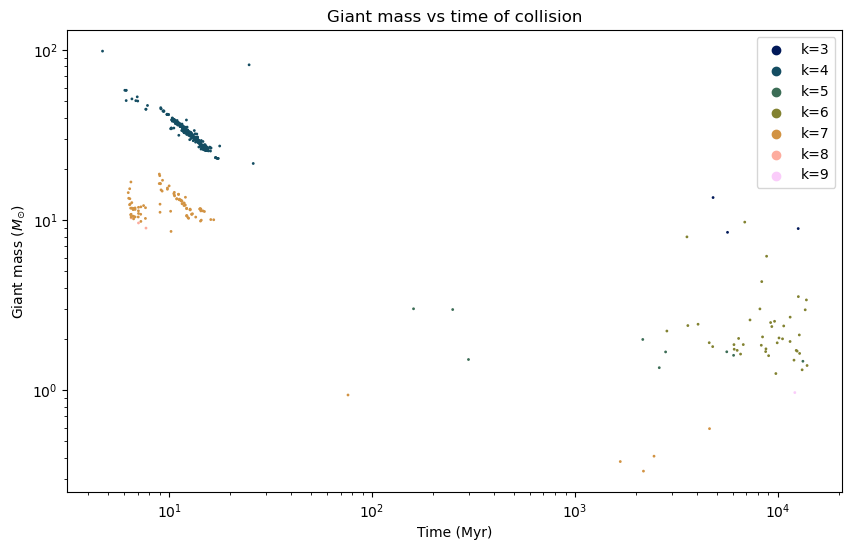

In [32]:
mass_BH = data[::, 9].astype(float)

mass_Giant = data[::, 11].astype(float)
type_Giant = data[::, 15].astype(float)
times_WDBH = data[::, 4].astype(float)


colors = cm.batlow(np.linspace(0, 1, len(set(type_Giant))))

# Get unique numbers from the list
unique_numbers = list(set(type_Giant))
unique_numbers.sort()

# Create a mapping of unique numbers to colors
N_to_color = {num: colors[i % len(colors)] for i, num in enumerate(unique_numbers)}
colors_N = [N_to_color[N] for N in type_Giant]


fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(times_WDBH, mass_Giant, s=1, color=colors_N)
ax.set_xlabel(r'Time (Myr)')
ax.set_ylabel(r'Giant mass ($M_{\odot}$)')
ax.set_title('Giant mass vs time of collision')
ax.set_xscale('log')
ax.set_yscale('log')


# Create a legend
legend_labels = {N: rf'k={int(N)}' for N in unique_numbers}
legend_handles = []
for N in unique_numbers:
    label = legend_labels[N]
    color = N_to_color[N]
    legend_handles.append(ax.scatter([], [], c=color, label=label))
ax.legend(handles=legend_handles, loc='best')

In [ ]:
# for idno,str_number in zip(ids,str_numbers):
#     # str_number = str_numbers[0]
#     # idno = ids[0]
#     log_path = f'data/updated_simulation_data/{str_number}/info/initial.binint.log'
#     conv_path = f'data/updated_simulation_data/{str_number}/info/initial.conv.sh'
#     conv = find_conv(conv_path)
#     print(conv)
#     parsed_log = parse_log_file(log_path, time_conv=conv['timeunitcgs'])

#     #print(len(parsed_log))
#     search_id = str(idno)
#     matching_sections = search_sections_by_id(parsed_log, search_id)

#         # for section in matching_sections:
#         #     print(section)
#     sorted_sections = sort_sections_by_time(matching_sections)
#     output_file_path = f'processed_data/binint_outputs/{str_number}_{idno}.txt'
#     write_matching_sections_to_file(sorted_sections, output_file_path)
